## Imports

In [11]:
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from tqdm import tqdm
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

from IPython.display import display

## Load Data

In [2]:
import seaborn as sns

In [3]:
data =  pd.read_csv('processed_data/train_norm_no' , index_col = 0)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,class,src_n,src_id,significance,flux_aper_hilim_s,flux_aper_hilim_u,flux_aper_hilim_m,flux_aper_hilim_h,flux_aper_hilim_b,flux_aper_lolim_s,...,flux_brems,flux_brems_lolim,flux_brems_hilim,brems_kt,brems_kt_hilim,brems_kt_lolim,brems_nh,brems_nh_hilim,brems_nh_lolim,brems_stat
0,NS,XMMU J004245.2+41172,NS0044,49.26,0.853540,0.584997,0.604768,0.609744,0.724001,0.826792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BH,J1745-2900,BH0027,337.00,0.201677,0.405622,0.284089,0.527613,0.516858,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BH,J1745-2900,BH0027,337.00,0.250868,0.305995,0.286632,0.566775,0.559071,0.183077,...,0.00816,0.001723,0.010962,0.04663,0.696288,0.027771,0.391576,0.440033,0.313944,0.09888
3,NS,1A 1742-289,NS0001,167.36,0.206103,0.401787,0.203195,0.451015,0.438906,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NS,XMMU J004245.2+41172,NS0044,49.26,0.642950,0.711407,0.555852,0.639998,0.651953,0.646214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']

In [5]:
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestClassifier 
clf = RandomForestClassifier()

# PCA

### Acc Function

In [6]:
def acc_df(train_scores , valid_scores , param_range, n_dim):
    df = pd.DataFrame(train_scores)
    df.insert(0 , 'num_trees' , param_range)
    df = df.set_index('num_trees')
    df_train = df.stack().reset_index().drop(columns=['level_1']).set_index('num_trees')
    df_train.columns = ['acc_val']
    df_train.insert(1 , 'acc_type' , ['train_acc']*len(df_train))
    df_train.insert(0 , 'n_dim' , [n_dim]*len(df_train))
    df_train

    df = pd.DataFrame(valid_scores)
    df.insert(0 , 'num_trees' , param_range)
    df = df.set_index('num_trees')
    df_test = df.stack().reset_index().drop(columns=['level_1']).set_index('num_trees')
    df_test.columns = ['acc_val']
    df_test.insert(1 , 'acc_type' , ['test_acc']*len(df_test))
    df_test.insert(0 , 'n_dim' , [n_dim]*len(df_test))
    df_test
    acc = pd.concat([df_train , df_test] , axis=0).reset_index()
    return acc

In [7]:
def pca_wrap(param_name , param_range , n_dim = 10 , ):
    np.random.seed(29832)
    indices = np.arange(data_label.shape[0])
    if(n_dim < data_val.shape[1]):
        data_pca = PCA(n_components=n_dim , whiten=True ).fit_transform(data_val)
    else : data_pca = data_val.copy().values
    X, y = data_pca[indices], data_label.iloc[indices]
    train_scores, valid_scores = validation_curve(clf, X, y, param_name=param_name, param_range=param_range,cv=5)
    acc = acc_df(train_scores , valid_scores, param_range , n_dim)
    return acc


In [ ]:
n_tree_range=np.arange(100,500 , 150)
n_dim_range = np.linspace(1.1,1.325 , num=16)**16
n_dim_range = [int(ti) for ti in n_dim_range ]
n_dim_range= np.append(n_dim_range[:-1],92)
n_dim_range= np.append(n_dim_range[:],6)
print(n_dim_range[:])
print(n_tree_range[:])
acc_02 = []

for pi in tqdm(n_dim_range):
    acc_02.append(pca_wrap('n_estimators' , n_tree_range , pi)) 



In [52]:
acc_all_02 = pd.concat(acc_02).reset_index(drop=True)
acc_all_02.insert(2 , 'impute_type' , ['Mean_impute']*len(acc_all_02))
acc_all_02

,num_trees,n_dim,impute_type,acc_val,acc_type
0,100,4,Mean_impute,1.000000,train_acc
1,100,4,Mean_impute,1.000000,train_acc
2,100,4,Mean_impute,1.000000,train_acc
3,100,4,Mean_impute,1.000000,train_acc
4,100,4,Mean_impute,1.000000,train_acc
...,...,...,...,...,...
505,400,6,Mean_impute,0.891304,test_acc
506,400,6,Mean_impute,0.815217,test_acc
507,400,6,Mean_impute,0.858696,test_acc
508,400,6,Mean_impute,0.815217,test_acc


In [26]:
acc_all = pd.concat(acc).reset_index(drop=True)
acc_all.insert(2 , 'impute_type' , ['Median_impute']*len(acc_all))
acc_all

,num_trees,n_dim,impute_type,acc_val,acc_type
0,100,4,Median_impute,1.000000,train_acc
1,100,4,Median_impute,1.000000,train_acc
2,100,4,Median_impute,1.000000,train_acc
3,100,4,Median_impute,1.000000,train_acc
4,100,4,Median_impute,1.000000,train_acc
...,...,...,...,...,...
505,400,92,Median_impute,0.880435,test_acc
506,400,92,Median_impute,0.945652,test_acc
507,400,92,Median_impute,0.858696,test_acc
508,400,92,Median_impute,0.913043,test_acc


In [53]:
acc_all = pd.concat([acc_all , acc_all_02]).reset_index(drop=True)

In [60]:
#sns.set_theme('paper')
sns.set_style('whitegrid')
colors = sns.color_palette('mako' ,n_colors=2)
#colors = sns.diverging_palette(240, 10, s=80, l=55, n=2 , center='dark')
to_plot = acc_all[acc_all['acc_type']=='test_acc']
to_plot = to_plot[to_plot['impute_type'].isin(['Zero_impute' , 'Corr_impute'])]
#to_plot = to_plot[to_plot['num_trees']>10]
acc_plot = sns.relplot(
    data = to_plot , kind='line' , 
    x = 'n_dim' , y = 'acc_val' , 
    hue = 'impute_type' ,
    height = 6 , aspect = 8/6,
    color = 'crest',
    #alpha=0.1
    palette= colors
)
acc_plot.set(xscale='log')
#acc_plot.set(yscale='log')
acc_plot.set(xticks=n_dim_range)
acc_plot.set(xticklabels=n_dim_range)
#plt.title('Perfomance on Lower decomposed dim')
#plt.ylabel('Test Accuracy')
#plt.xlabel('Dimensions')
plt.savefig('result/pca_dim_plot.png')
plt.show()

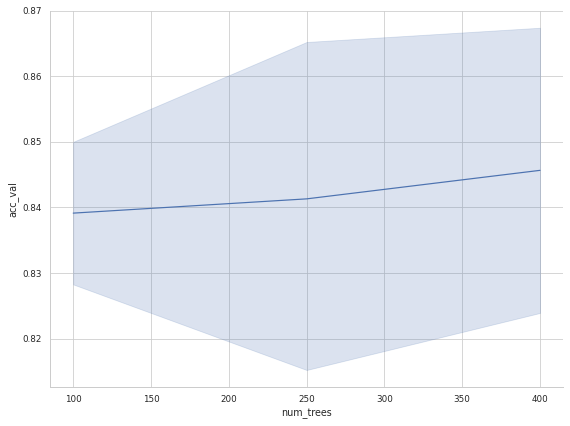

In [20]:
sns.set_theme('paper')
sns.set_style('whitegrid')
palette = sns.color_palette("mako_r", 4)
to_plot = acc_all[acc_all['acc_type']=='test_acc']
to_plot = to_plot[to_plot['n_dim']==7]
acc_plot = sns.relplot(
    data = to_plot , kind='line' , 
    x = 'num_trees' , y = 'acc_val' , 
    #hue = 'num_trees' ,
    height = 6 , aspect = 8/6,
    palette='copper'
)
#acc_plot.set(xscale='log')
#acc_plot.set(yscale='log')
#acc_plot.set(xticks=n_dim_range)
#acc_plot.set(xticklabels=n_dim_range)
plt.show()

# Hyper Parameter Tuning

In [52]:
rfc_v2 = RandomForestClassifier()

## Random Search

In [53]:
from sklearn.model_selection import RandomizedSearchCV

In [112]:
n_estimators = [int(x) for x in np.linspace(80 , 450 , num=40)]
max_features = ['log2' , 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 150, num = 40)]
min_samples_split = [int(x) for x in np.linspace(2,20 ,num = 30)]
min_samples_leaf = [int(x) for x in np.linspace(2,30 , num = 30)]
bootstrap = [True , False]

In [113]:
params_dict = {
    'n_estimators' : n_estimators , 
    'max_features' : max_features ,
    'max_depth' :max_depth , 
    'min_samples_split' : min_samples_split , 
    'min_samples_leaf' : min_samples_leaf, 
    'bootstrap' : bootstrap 
}

In [114]:
rs = RandomizedSearchCV(
    rfc_v2 , 
    params_dict , 
    n_iter = 600,
    cv = 5 ,
    verbose = 5 ,
    n_jobs=-1 , 
    random_state= 0 
)

In [115]:
rs.fit(data_val , data_label)
rs.best_params_

Fitting 5 folds for each of 600 candidates, totalling 3000 fits


{'n_estimators': 345,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 43,
 'bootstrap': False}

In [116]:
rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
rs_df = rs_df.drop([
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time',
            'std_score_time', 
            'params', 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'],
            axis=1)
rs_df.head(10)

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,split3_test_score,split4_test_score,mean_test_score,rank_test_score
0,345,5,2,sqrt,43,False,0.967391,0.945652,0.934783,1
1,250,6,2,sqrt,104,False,0.967391,0.945652,0.932609,2
2,174,2,2,sqrt,81,False,0.967391,0.945652,0.932609,2
3,288,8,2,sqrt,130,False,0.956522,0.945652,0.932609,2
4,193,11,4,sqrt,119,False,0.956522,0.934783,0.930435,5
5,402,7,2,sqrt,146,False,0.945652,0.945652,0.930435,5
6,89,8,2,sqrt,27,False,0.956522,0.923913,0.930435,5
7,184,12,2,sqrt,127,False,0.967391,0.945652,0.930435,5
8,326,6,5,sqrt,16,False,0.956522,0.945652,0.928261,9
9,155,16,2,sqrt,88,False,0.923913,0.934783,0.928261,10


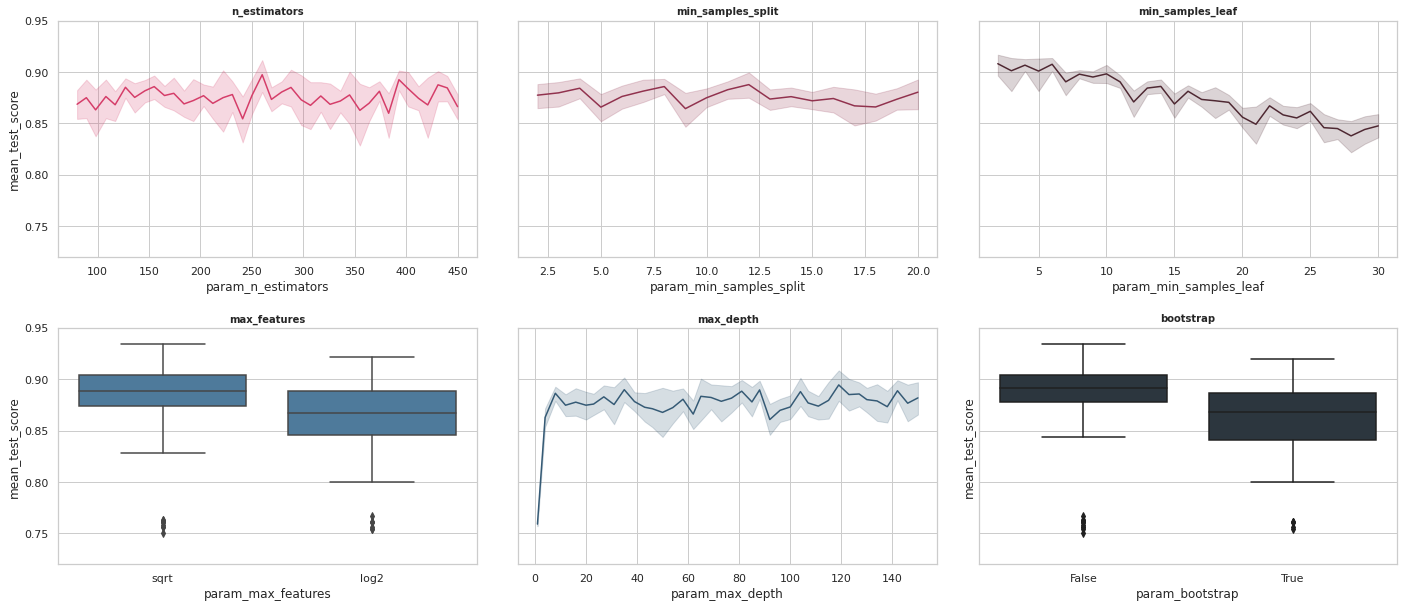

In [120]:
sns.set(style="whitegrid", color_codes=True, font_scale = 1)
fig, axs = plt.subplots(ncols=3, nrows=2  , sharey=True)
fig.set_size_inches(24,10)
colors = sns.diverging_palette(240, 0, n=6 , center='dark')
sns.lineplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0],color=colors[5]) 
axs[0,0].set_ylim([.72,.95])
axs[0,0].set_title(label = 'n_estimators', size=10, weight='bold')
sns.lineplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1],color=colors[4])
#axs[0,1].set_ylim([.85,.93])
axs[0,1].set_title(label = 'min_samples_split', size=10, weight='bold')
sns.lineplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2],color=colors[3])
#axs[0,2].set_ylim([.80,.93])
axs[0,2].set_title(label = 'min_samples_leaf', size=10, weight='bold')
sns.boxplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0],color=colors[0])
#axs[1,0].set_ylim([.88,.92])
axs[1,0].set_title(label = 'max_features', size=10, weight='bold')
sns.lineplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1],color=colors[1])
#axs[1,1].set_ylim([.80,.93])
axs[1,1].set_title(label = 'max_depth', size=10, weight='bold')
sns.boxplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2] , color=colors[2])
#axs[1,2].set_ylim([.88,.92])
axs[1,2].set_title(label = 'bootstrap', size=10, weight='bold')
fig.subplots_adjust(wspace=0.1 , hspace=0.3)

plt.show()


### Result
> Best Model Parameters
```
{'n_estimators': 345,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 43,
 'bootstrap': False}
```
> Best Parameter values

```
{'n_estimators': [309 , 347,385],
 'min_samples_split': [7,12,44],
 'min_samples_leaf': [2,7,12],
 'max_features': 'sqrt',
 'max_depth': [43 ,85, 100],
 'bootstrap': False}
```

## Grid Search

In [121]:
from sklearn.model_selection import GridSearchCV

In [122]:
n_estimators = [140 , 170 , 230]
max_features = ['sqrt'] 
bootstrap = [False]
max_depth =  [56 ,85, 100]
min_samples_leaf = [2,12]
min_samples_split = [7,18,28]

In [20]:
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [24]:
gs = GridSearchCV(rfc_v2 , param_grid , cv=5 , verbose=5 , n_jobs=-1)
gs.fit(data_val , data_label)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [56, 85, 100],
                         'max_features': ['sqrt'], 'min_samples_leaf': [2, 12],
                         'min_samples_split': [7, 18, 28],
                         'n_estimators': [140, 170, 230]},
             verbose=5)

In [25]:
gs.best_params_

{'bootstrap': False,
 'max_depth': 56,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 140}

# Comparison

### Train-test split

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cf 
from sklearn.ensemble import RandomForestClassifier

In [20]:
data =  pd.read_csv('processed_data/train_norm_rf_impute' , index_col = 0)
np.random.seed(433)
data = data.sample(frac=1).reset_index(drop=True)
split = int(0.8*(len(data)))
info_col = [ 'class' , 'src_n' , 'src_id' , 'significance']
data_info = data[info_col]
data_val = data.drop(columns=info_col) 
data_label = data['class']
x = data_val.copy()
y = data_label.copy()
x_train, x_test , y_train , y_test = x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)

### Monte Carlo Cross Validation 

In [5]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
def mc_validation(model_func , x  , y , model_name = '' , pca=False):
    train_acc = []
    test_acc = []

    for i in tqdm(range(32)):
        x_train , x_test , y_train , y_test = train_test_split(x,y , test_size=0.2)
        if(pca):
            pca = PCA(n_components=7)
            x_train = pca.fit_transform(x_train)
            x_test = pca.transform(x_test)
        clf = model_func
        clf.fit(x_train , y_train)
        #print('train , test' , y_train.shape , y_test.shape)
        #print(clf.score(x_test, y_test))
        test_acc.append(clf.score(x_test , y_test))
        train_acc.append(clf.score(x_train , y_train))

    acc_train =  pd.DataFrame()
    acc_test = pd.DataFrame()

    
    acc_test.insert(0 , 'acc_type' , ['Test_acc']*len(train_acc))
    acc_test.insert(1 , 'accuracy' , test_acc)
    acc_test = acc_test.reset_index(drop=True)
   
    acc_train.insert(0 , 'acc_type' , ['Train_acc']*len(train_acc))
    acc_train.insert(1 , 'accuracy' , train_acc)
    acc_train = acc_train.reset_index(drop=True)

    acc = pd.concat([acc_train , acc_test]).reset_index(drop=True)
    acc.insert(0 , 'model' , [model_name]*len(acc))
    return acc


## Vanilla RF

In [6]:
rf_vanila = RandomForestClassifier(n_estimators=300)
rf_vanila.fit(x_train , y_train)
y_pred_vanila = rf_vanila.predict(x_test)
cf_vanila = cf(y_test , y_pred_vanila)
print(cf_vanila) 

[[27  5]
 [ 5 55]]


In [7]:
rf_vanila.score(x_test, y_test)

0.8913043478260869

In [8]:
print(y_train.shape , y_test.shape)

(368,) (92,)


In [9]:
acc_vanila = mc_validation(rf_vanila , data_val , data_label, model_name='Vanila_RF').reset_index(drop=True)


100%|██████████| 32/32 [00:24<00:00,  1.28it/s]


In [10]:
acc_vanila.to_csv('result/acc_vanila.csv')
acc_vanila

,model,acc_type,accuracy
0,Vanila_RF,Train_acc,1.000000
1,Vanila_RF,Train_acc,1.000000
2,Vanila_RF,Train_acc,1.000000
3,Vanila_RF,Train_acc,1.000000
4,Vanila_RF,Train_acc,1.000000
...,...,...,...
59,Vanila_RF,Test_acc,0.913043
60,Vanila_RF,Test_acc,0.869565
61,Vanila_RF,Test_acc,0.956522
62,Vanila_RF,Test_acc,0.923913


## Vanilla RF with PCA

In [95]:
from sklearn.decomposition import PCA

In [96]:
pca = PCA(n_components=7 ,svd_solver='full' , random_state=2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

rf_van_pca = RandomForestClassifier(n_estimators=300)
rf_van_pca.fit(x_train_pca , y_train)
y_pred_van_pca = rf_van_pca.predict(x_test_pca)
cf_van_pca = cf(y_test , y_pred_van_pca)
print(cf_van_pca) 

[[23  9]
 [ 8 52]]


In [97]:
acc_vanila_pca = mc_validation(rf_van_pca , data_val , data_label ,model_name = 'vanila_rf_PCA' ,  pca=True ,).reset_index(drop=True)

100%|██████████| 32/32 [00:23<00:00,  1.39it/s]


In [98]:
acc_vanila_pca.to_csv('result/acc_vanila_pca.csv')

## Tuned RF

{'n_estimators': 345,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 43,
 'bootstrap': False}

In [127]:
rf_t = RandomForestClassifier(n_estimators=340 ,
        min_samples_split = 5 ,
        min_samples_leaf = 2 , 
        max_depth = 43 , 
        bootstrap=False , 
        max_features = 'sqrt',
        )
rf_t.fit(x_train , y_train)


RandomForestClassifier(bootstrap=False, max_depth=43, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=340)

In [128]:

y_pred_t = rf_t.predict(x_test)
cf_t = cf(y_test , y_pred_t)
(cf_t)

array([[27,  5],
       [ 3, 57]])

In [129]:
acc_tuned = mc_validation(rf_t , data_val , data_label, model_name='Tuned_RF').reset_index(drop=True)
acc_tuned.to_csv('result/acc_tuned.csv')
acc_tuned

100%|██████████| 32/32 [00:27<00:00,  1.15it/s]


,model,acc_type,accuracy
0,Tuned_RF,Train_acc,1.000000
1,Tuned_RF,Train_acc,1.000000
2,Tuned_RF,Train_acc,1.000000
3,Tuned_RF,Train_acc,1.000000
4,Tuned_RF,Train_acc,1.000000
...,...,...,...
59,Tuned_RF,Test_acc,0.934783
60,Tuned_RF,Test_acc,0.847826
61,Tuned_RF,Test_acc,0.902174
62,Tuned_RF,Test_acc,0.902174


## Result

In [119]:
acc_vanila = pd.read_csv('result/acc_vanila.csv')
acc_tuned = pd.read_csv('result/acc_tuned.csv')
acc_vanila_pca = pd.read_csv('result/acc_vanila_pca.csv')

In [120]:
acc = acc_vanila.copy()
display(acc[acc['acc_type'] == 'Test_acc'][['accuracy']].describe().head(3))
acc = acc_vanila_pca.copy()
display(acc[acc['acc_type'] == 'Test_acc'][['accuracy']].describe().head(3))
acc = acc_tuned.copy()
display(acc[acc['acc_type'] == 'Test_acc'][['accuracy']].describe().head(3))

,accuracy
count,32.000000
mean,0.921196
std,0.028155


,accuracy
count,32.000000
mean,0.827446
std,0.041574


,accuracy
count,32.000000
mean,0.926291
std,0.029957


In [121]:
acc = pd.concat([acc_vanila, acc_vanila_pca , acc_tuned]).reset_index(drop=True)
acc.to_csv('result/acc_sklearn_rf_all.csv')

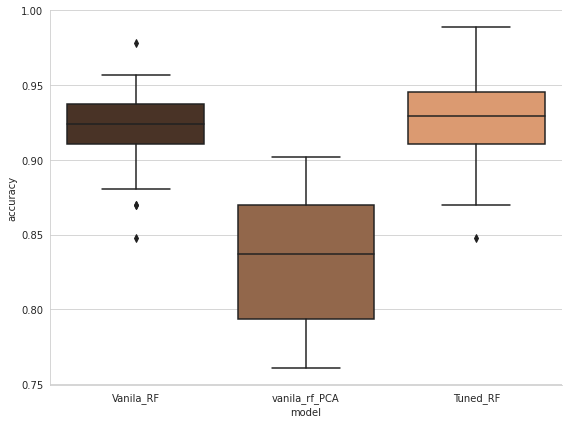

In [122]:
sns.set_style('whitegrid')
pal = sns.diverging_palette(240, 10, s=80, l=55, n=3)
acc = pd.read_csv('result/acc_sklearn_rf_all.csv')
sns.catplot(data = acc[acc['acc_type']=='Test_acc'] , y='accuracy' , x = 'model' ,
            kind='box' ,  # hue='acc_type',
            palette = 'copper' , 
            height=6 , aspect=8/6
            )
plt.savefig('result/param_tuning_res_box.jpg')
plt.show()

# Best Random Forest

So Now we have identified best random Forest , lets see how its various performance are.

## Load Data

In [17]:
data =  pd.read_csv('processed_data/train_norm_median' , index_col = 0)
np.random.seed(433)
data = data.sample(frac=1).reset_index(drop=True)
data_label = data['class']
x = data.copy().reset_index(drop=True)
y = data_label.copy().reset_index(drop=True)
x_train, x_test , y_train , y_test = train_test_split(x,y , test_size=0.2 , stratify=y)


#x_train ,x_test = src_split(x)
id_train = x_train['src_id'].reset_index(drop=True)
id_test = x_test['src_id'].reset_index(drop=True)
n_train = x_train['src_n'].reset_index(drop=True)
n_test = x_test['src_n'].reset_index(drop=True)
y_train = x_train['class'].reset_index(drop=True)
y_test = x_test['class'].reset_index(drop=True)
x_train = x_train.drop(columns=[  'class' , 'src_n' ,'src_id' ,'significance' ,  ]).reset_index(drop=True)
x_test = x_test.drop(columns=[  'class' , 'src_n' ,'src_id' ,'significance', ]).reset_index(drop=True)


## Train and save model

In [18]:
clf = RandomForestClassifier(n_estimators=340 ,
        min_samples_split = 5 ,
        min_samples_leaf = 2 , 
        max_depth = 43 , 
        bootstrap=False , 
        max_features = 'sqrt',
        random_state=89
        )
#clf = RandomForestClassifier(n_estimators=300)
clf.fit(x_train , y_train)


RandomForestClassifier(bootstrap=False, max_depth=43, max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=5,
                       n_estimators=340, random_state=89)

In [19]:
print(clf.score(x_test , y_test))

cf = confusion_matrix(y_test , clf.predict(x_test))
print(cf)

0.9239130434782609
[[28  4]
 [ 3 57]]


## Feature Importace

In [54]:
feat_imp = clf.feature_importances_
feat_names = x_train.columns.to_list()
feat = pd.DataFrame()
feat.insert( 0 , 'feat_name' , feat_names)
feat.insert(1 , 'feat_imp' , feat_imp)
feat = feat.sort_values(by = 'feat_imp' , ascending=False).reset_index(drop=True)
feat_names_sorted = feat['feat_name']
display(feat)
feat.to_csv('result/feat_imp.csv')

,feat_name,feat_imp
0,var_inter_index,0.116844
1,var_inter_prob,0.098465
2,photflux_aper_u,0.048618
3,var_inter_sigma,0.043734
4,photflux_aper_hilim_u,0.038030
...,...,...
87,bb_stat,0.000537
88,bb_nh_hilim,0.000342
89,flux_bb_lolim,0.000243
90,bb_nh,0.000122


## Bake Result

### Function

In [130]:
def create_res_data(x , y , id , n , cl_type):
    pred = clf.predict(x)
    pred_prob = np.asarray(clf.predict_proba(x))
    pred_prob_bh = pred_prob[:,0]
    pred_prob_ns = pred_prob[:,1]
    pred_prob = [np.amax(pi) for pi in pred_prob]

    res =  x[feat_names_sorted].copy().reset_index(drop=True)
    res.insert(0 , 'clf_type' , [cl_type]*len(res))
    res.insert(0 , 'src_id' , id)
    res.insert(1, 'src_n' , n)
    res.insert(2 , 'true_class' , y)
    res.insert(3 ,'pred_class' , pred)
    res.insert(4 , 'pred_prob' , pred_prob)
    res.insert(5 , 'BH_prob' , pred_prob_bh)
    res.insert(6 , 'NS_prob' , pred_prob_ns)
    truth = []
    th_class = [] 
    is_ok = [] 
    for tc , pc , pp in zip(res['true_class'] , res['pred_class'] , res['pred_prob']):
        if(tc==pc): is_ok.append(1)
        else: is_ok.append(0)
        if(pp > 0.80):
            th_class.append(pc)
            if(tc==pc):
                truth.append(1)
            else: truth.append(0)
        else :
            truth.append(2)
            th_class.append('X')
    res.insert(5 , 'th_class' , th_class )
    res.insert(6 , 'truth' , truth)
    res.insert(6 , 'is_ok' , is_ok)
    #display(res)
    return res


### Bake it

In [131]:

train_res = create_res_data(x_train , y_train , id_train , n_train , cl_type='train')
test_res = create_res_data(x_test , y_test , id_test , n_test , cl_type='test')
#train_res.to_csv('result/train_res_rf.csv')
#test_res.to_csv('result/test_res_rf.csv')
res_data = pd.concat([train_res , test_res]).reset_index(drop=True)
res_data.to_csv('result/res_rf_tuned_median.csv')